In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
import itertools
from IPython.display import Audio
import librosa
import librosa.display as dsp
import pandas as pd
from random import shuffle

import os
gpu_boole = torch.cuda.is_available()

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
mnist = MNIST('./data', train=True, transform=tfs.Compose([tfs.ToTensor()]), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 901kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.2kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 243kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.75MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sripaadsrinivasan/audio-mnist")

print("Path to dataset files:", path)

100%|██████████| 948M/948M [00:52<00:00, 18.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sripaadsrinivasan/audio-mnist/versions/1


In [ ]:
# preprocessing reference: https://www.kaggle.com/code/padmanabhanporaiyar/audio-mnist-classification-98-accuracy#Modelling%F0%9F%A4%96

def get_audio(digit=0):
    # Audio Sample Directory
    sample = np.random.randint(1,60)
    # Index of Audio
    index = np.random.randint(1,5)

    # Modified file location
    if sample<10:
        file = f"{path}/data/{sample}/{digit}_0{sample}_{index}.wav"
    else:
        file = f"{path}/data/{sample}/{digit}_{sample}_{index}.wav"


    # Get Audio from the location
    data,sample_rate = librosa.load(file)

    # Plot the audio wave
    dsp.waveshow(data,sr=sample_rate)
    plt.show()

    # Show the widget
    return Audio(data=data,rate=sample_rate)

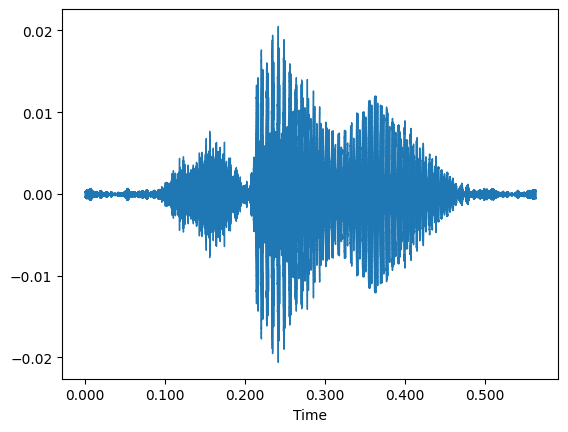

In [ ]:
get_audio(0)

In [ ]:
def extract_features(file):
    # Load audio and sample rate of audio
    audio,sample_rate = librosa.load(file)
    # Extract features using mel-frequency coefficient
    extracted_features = librosa.feature.mfcc(y=audio,
                                              sr=sample_rate,
                                              n_mfcc=40)

    # Scale the extracted features
    extracted_features = np.mean(extracted_features.T,axis=0)
    # Return the extracted features
    return extracted_features


def preprocess_and_create_dataset():
    # Path of folder where the audio files are present
    root_folder_path = path + "/data/"
    # Empth List to create dataset
    dataset = []

    # Iterating through folders where each folder has audio of each digit
    for folder in tqdm(range(1,61),colour='green'):
        if folder<10:
            # Path of the folder
            folder = os.path.join(root_folder_path,"0"+str(folder))
        else:
            folder = os.path.join(root_folder_path,str(folder))

        # Iterate through each file of the present folder
        for file in tqdm(os.listdir(folder),colour='blue'):
            # Path of the file
            abs_file_path = os.path.join(folder,file)
            # Pass path of file to extracted_features() function to create features
            extracted_features = extract_features(abs_file_path)
            # Class of the audio,i.e., the digit it represents
            class_label = file[0]

            # Append a list where the feature represents a column and class of the digit represents another column
            dataset.append([extracted_features,class_label])

    # After iterating through all the folder convert the list to a dataframe
    print("Extracted Features and Created Dataset Successfully !!")
    return pd.DataFrame(dataset,columns=['features','class'])

In [ ]:
dataset = preprocess_and_create_dataset()

100%|██████████| 60/60 [05:51<00:00,  5.87s/it]

Extracted Features and Created Dataset Successfully !!


In [ ]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(dataset, test_size=0.3, stratify=dataset['class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'])

print(f'training size: {train_df.shape} \nvalidation size: {val_df.shape} \ntest size: {test_df.shape} \n')

training size: (21000, 2) 
validation size: (4500, 2) 
test size: (4500, 2) 



In [ ]:
# check dataset
print(np.vstack(train_df['features'].values).shape)
train_df['features'].values.shape

(21000, 40)


(21000,)

In [ ]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = torch.tensor(np.vstack(data['features'].values))

        self.labels = torch.tensor(np.vstack(data['class'].astype(np.float32).values))

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(train_df)
val_dataset = CustomDataset(val_df)
test_dataset = CustomDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
def ELBO(recon_x, x, z_mu, z_logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    elbo = BCE + KLD
    return elbo

In [ ]:
def accuracy(recon_x, model, label):
    y_pred = model(recon_x)
    _, label_pred = torch.max(y_pred, 1)
    correct = (label_pred == label.flatten()).sum().item()
    return correct

In [ ]:
# accuracy net reference: https://github.com/pytorch/examples/blob/main/mnist/main.py

class AccuracyNet(nn.Module):
    def __init__(self):
        super(AccuracyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
# 99% accuracy model for MNIST

accuracy_model = AccuracyNet()
# accuracy_model.load_state_dict(torch.load("mnist_cnn.pt", weights_only=True))
accuracy_model.load_state_dict(torch.load("accuracy_model.pt", weights_only=True)) #fine-tuned accuracy model

<All keys matched successfully>

In [ ]:
class ATInet(nn.Module):

    def __init__(self,input_length, latent_length):
        super(ATInet, self).__init__()
        self.k = latent_length

        self.en_linear1 = nn.Linear(input_length, 512)
        self.en_linear2 = nn.Linear(512, 256)
        self.en_linear3 = nn.Linear(256, 128)
        self.en_linear4 = nn.Linear(128, self.k * 2)

        self.en_bn1 = nn.BatchNorm1d(512)
        self.en_bn2 = nn.BatchNorm1d(256)
        self.en_bn3 = nn.BatchNorm1d(128)

        self.de_conv1 = nn.ConvTranspose2d(self.k, 16, 4, 1, 1)
        self.de_conv2 = nn.ConvTranspose2d(16, 8, 4, 2, 0)
        self.de_conv3 = nn.ConvTranspose2d(8, 4, 4, 2, 0)
        self.de_conv4 = nn.ConvTranspose2d(4, 1, 4, 2, 1)

        self.de_bn1 = nn.BatchNorm2d(16)
        self.de_bn2 = nn.BatchNorm2d(8)
        self.de_bn3 = nn.BatchNorm2d(4)
        self.de_bn4 = nn.BatchNorm2d(1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def encode(self, x):
        out = self.relu(self.en_bn1(self.en_linear1(x)))
        out = self.relu(self.en_bn2(self.en_linear2(out)))
        out = self.relu(self.en_bn3(self.en_linear3(out)))
        out = self.en_linear4(out)
        mu = out[:, :self.k]
        logvar = out[:, self.k:]
        return mu, logvar

    def decode(self, z):
        out = self.relu(self.de_bn1(self.de_conv1(z)))
        out = self.relu(self.de_bn2(self.de_conv2(out)))
        out = self.relu(self.de_bn3(self.de_conv3(out)))
        out = self.sigmoid(self.de_bn4(self.de_conv4(out)))
        return out

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterization(z_mu, torch.exp(0.5 * z_logvar)).view(-1, self.k, 1, 1)
        recon_x = self.decode(z)
        return recon_x, z_mu, z_logvar

In [ ]:
mnist = MNIST('./data', train=True, transform=tfs.Compose([tfs.ToTensor()]), download=True)

In [ ]:
img_class = [[] for i in range(10)]

for i in range(60000):
    img, y = mnist.__getitem__(i)
    img_class[y].append(img)

In [ ]:
class Imgset():
    def __init__(self, labels, imgs):
        self.img_dict = {l: i for l, i in zip(labels, imgs)}

    def class2img(self, labels):
        imgs = []
        for label in labels.flatten():
            class_img = self.img_dict[label.cpu().data.numpy().item()]
            shuffle(class_img)
            imgs.append(class_img[0])
        return torch.stack(imgs)

In [ ]:
def train(model, optimizer, loss_func, acc_func, lr, num_epochs, mnist_img, acc_model):
    history = {'train_loss': [],  'val_acc': []}

    # Move model to the appropriate device
    if gpu_boole:
        model.cuda()
        acc_model.cuda()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()  # Set model to training mode
        train_loss_total = 0.0
        total_train_samples = 0

        for inputs, labels in train_loader:
            if gpu_boole:
                inputs, labels = inputs.cuda(), labels.cuda()

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs, z_mu, z_logvar = model(inputs)
            targets = mnist_img.class2img(labels)
            if gpu_boole:
                targets = targets.cuda()
            loss = loss_func(outputs, targets, z_mu, z_logvar)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update metrics
            train_loss_total += loss.item()
            total_train_samples += labels.size(0)

        model.eval()
        val_total = 0
        val_correct = 0
        for inputs, labels in train_loader:
            if gpu_boole:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs, z_mu, z_logvar = model(inputs)
            targets = mnist_img.class2img(labels)
            if gpu_boole:
                targets = targets.cuda()
            correct = acc_func(outputs, acc_model, labels)

            val_correct += correct
            val_total += labels.size(0)
        train_loss = train_loss_total / total_train_samples
        val_acc = val_correct / val_total



        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)

        print('[%d/%d] - train_loss: %.3f, val_accuracy: %.3f' % ((num_epochs + 1), num_epochs, train_loss, val_acc))

    return history

In [ ]:
model = ATInet(input_length=40, latent_length=100)
lr = 0.001
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr)
history = train(model, optimizer, ELBO, accuracy, lr, num_epochs, Imgset(range(10), img_class), accuracy_model)

Epoch 1/10
[11/10] - train_loss: 433.301, val_accuracy: 0.291
Epoch 2/10
[11/10] - train_loss: 315.778, val_accuracy: 0.445
Epoch 3/10
[11/10] - train_loss: 260.830, val_accuracy: 0.543
Epoch 4/10
[11/10] - train_loss: 231.835, val_accuracy: 0.592
Epoch 5/10
[11/10] - train_loss: 215.556, val_accuracy: 0.583
Epoch 6/10
[11/10] - train_loss: 206.197, val_accuracy: 0.671
Epoch 7/10
[11/10] - train_loss: 199.803, val_accuracy: 0.681
Epoch 8/10
[11/10] - train_loss: 196.000, val_accuracy: 0.714
Epoch 9/10
[11/10] - train_loss: 192.964, val_accuracy: 0.739
Epoch 10/10
[11/10] - train_loss: 190.816, val_accuracy: 0.745


tensor([[8.],
        [9.],
        [6.],
        [4.],
        [7.],
        [4.],
        [8.],
        [6.],
        [7.],
        [7.],
        [4.],
        [8.],
        [1.],
        [6.],
        [7.],
        [4.],
        [7.],
        [6.],
        [4.],
        [0.],
        [4.],
        [6.],
        [4.],
        [0.],
        [3.],
        [9.],
        [5.],
        [9.],
        [6.],
        [5.],
        [1.],
        [5.]], device='cuda:0')


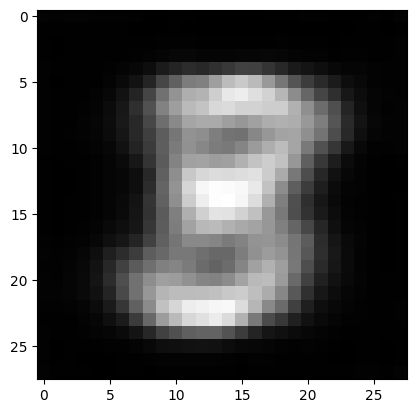

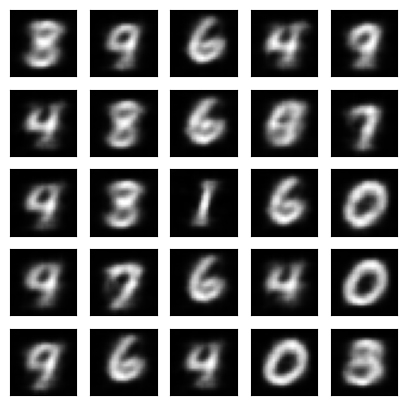

In [ ]:
for inputs, labels in test_loader:
    if gpu_boole:
        inputs, labels = inputs.cuda(), labels.cuda()
    imgs, _, _ = model(inputs)
    imgs = imgs.cpu().data.numpy().reshape([32,28,28])
    plt.imshow(imgs[0],cmap='gray')
    print(labels)

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for kr in range(5*5):
        i = kr // 5
        j = kr % 5
        ax[i, j].cla()
        ax[i, j].imshow(imgs[kr], cmap='gray')

    break


In [ ]:
#fine-tuning accuracy model

for inputs, labels in val_loader:
    if gpu_boole:
        inputs, labels = inputs.cuda(), labels.cuda()
        accuracy_model.cuda()
    imgs, _, _ = model(inputs)
    break

imgs = imgs.cpu().data.numpy()
imgs = torch.Tensor(imgs)
acc_dataset = data.TensorDataset(imgs, labels)
acc_loader = DataLoader(acc_dataset, batch_size=10, shuffle=True)

accuracy_model.fc1 = nn.Linear(9216, 128)
accuracy_model.fc2 = nn.Linear(128, 10)
optimizer = torch.optim.Adam(list(accuracy_model.fc1.parameters()) + list(accuracy_model.fc2.parameters()), 0.001)
loss_func = nn.CrossEntropyLoss()
for epoch in range(50):
    print(f"Epoch {epoch+1}/{50}")

    # Training phase
    accuracy_model.train()  # Set model to training mode
    accuracy_model = accuracy_model.cuda()
    for inputs, labels in acc_loader:
        labels = labels.type(torch.LongTensor).flatten()
        if gpu_boole:
            inputs, labels = inputs.cuda(), labels.cuda()


        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = accuracy_model(inputs)

        acc_loss = loss_func(outputs, labels)

        # Backward pass and optimization
        acc_loss.backward()
        optimizer.step()

accuracy_model.eval()
torch.save(accuracy_model.state_dict(), "accuracy_model.pt")

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [ ]:
total = 0
correct = 0
for inputs, labels in test_loader:
    if gpu_boole:
        inputs, labels = inputs.cuda(), labels.cuda()
        accuracy_model.cuda()
    imgs, _, _ = model(inputs)
    correct += accuracy(imgs, accuracy_model, labels)
    total += labels.size(0)

print("Test Accuracy:", correct / total)

Test Accuracy: 0.8228888888888889
